Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 8)           0

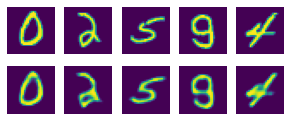

In [1]:
# Data_Augmentation

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np

(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

autoencoder = Sequential()

# 인코딩
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

# 디코딩 
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

# 전체 구조를 확인
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

random_test = np.random.randint(X_test.shape[0], size=5)  #테스트할 이미지를 랜덤하게 불러옴
ae_imgs = autoencoder.predict(X_test)  #앞서 만든 오토인코더 모델에 input

plt.figure(figsize=(7, 2))  #출력될 이미지의 크기

for i, image_idx in enumerate(random_test):    #랜덤하게 뽑은 이미지를 차례로 나열
   ax = plt.subplot(2, 7, i + 1) 
   plt.imshow(X_test[image_idx].reshape(28, 28))  #테스트할 이미지
   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)
   plt.imshow(ae_imgs[image_idx].reshape(28, 28))  #오토인코딩 결과
   ax.axis('off')
plt.show()



Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_____________________________________________

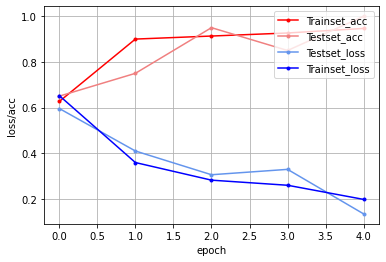

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16

np.random.seed(3)
tf.compat.v1.set_random_seed(3)

train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
       '../../../../../dlevery/run_project/train',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
       '../../../../../dlevery/run_project/test',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()

finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64, activation='relu'))
finetune_model.add(Dense(2, activation='softmax'))
finetune_model.summary()

finetune_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

history = finetune_model.fit_generator(
       train_generator,
       steps_per_epoch=30,
       epochs=5,
       validation_data=test_generator,
       validation_steps=4)

acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, acc, marker='.', c="red", label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()